# Imports

In [ ]:
# import section
import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt
import scipy
import os
import math
import cv2
from skimage import feature
import skimage

from google.colab import drive
from google.colab import files

from math import sqrt,exp
!pip install scipy==1.6.2

# Mount Drive

In [ ]:
drive.mount("/content/drive", force_remount=True)
%ls
%cd '/content/drive/MyDrive/Colab Notebooks/V&P/assignment2_imageProcessing'
%ls

Mounted at /content/drive
drive/  sample_data/
/content/drive/MyDrive/Colab Notebooks/V&P/assignment2_imageProcessing
CV_assignment_ImageProcessing_2.pdf  exercise_13_no.ipynb
es10/                                instance_exercise1-7.ipynb
es11/                                plot1.png
es12/                                plot2.png
es13/                                plot.png
exercise_10.ipynb                    sample_image_fast.jpg
exercise_11.ipynb                    sample_image_harris.jpg
exercise_12.ipynb                    try1-7Exercise.ipynb
exercise_13.ipynb                    working_env_harris.jpg


# load images and denoise

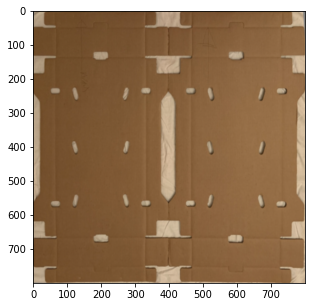

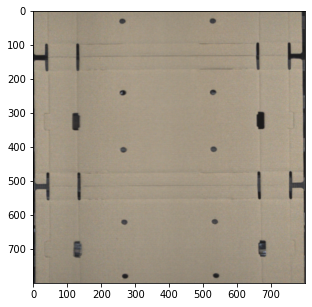

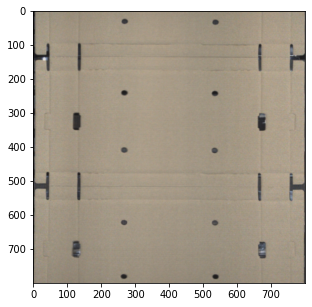

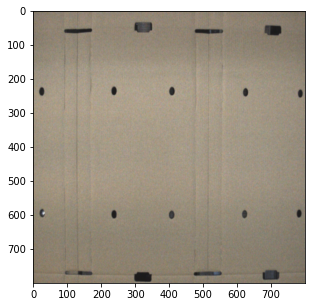

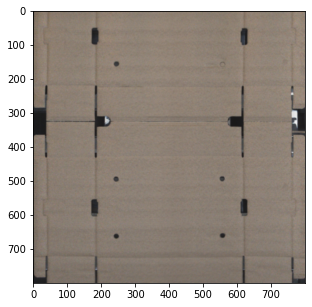

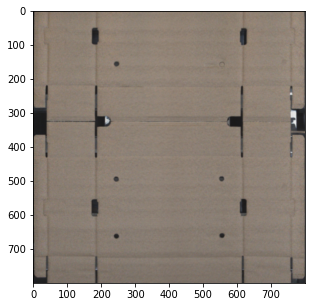

In [ ]:
def getFiles(path, show_it = False, grey = True, denoise = True):
    images = []
    for file in  os.listdir(path):
          img = cv2.imread(path + "/" + file)
          img = cv2.resize(img,(800,800))
          if grey:
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
          else:
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
          if denoise:
            img = cv2.GaussianBlur(img,(3,3),cv2.BORDER_REFLECT)
          if show_it:
              fig,ax = plt.subplots(figsize=(7, 5))
              ax.imshow(img, cmap=plt.cm.gray)
          images.append(img)
          # print(file)
          # print(np.min(img))
          # print(np.max(img))
    return images



images_bw = getFiles("./es10", show_it = False)
images_rgb = getFiles("./es10", show_it = True, grey = False)
n_images = len(images_bw)

#morphological operations

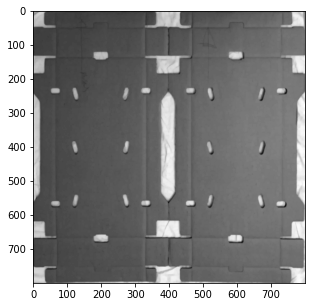

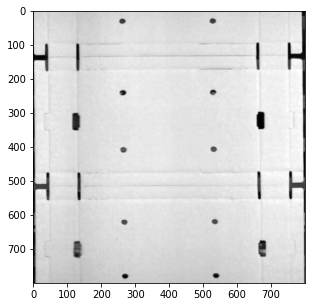

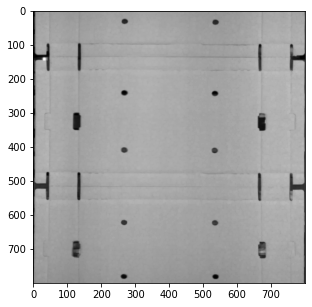

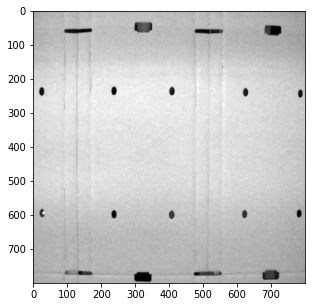

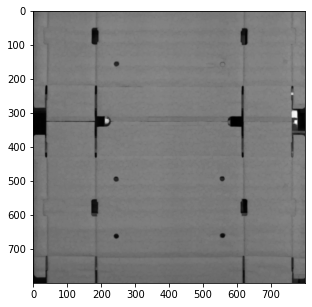

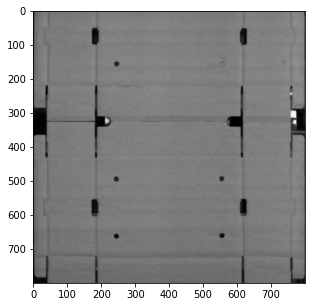

In [ ]:
mp_images = [] 
dim = 5

# application of opening 'cause' the main lines are darker
for img in images_bw:

  opening = scipy.ndimage.grey_erosion(img, footprint=np.ones((dim,dim)))
  opening = scipy.ndimage.grey_dilation(opening, footprint=np.ones((dim,dim)))
  

  mp_images.append(opening)
  fig,ax = plt.subplots(figsize=(7, 5))
  ax.imshow(opening, cmap=plt.cm.gray)

# 1) extraction of informative edges

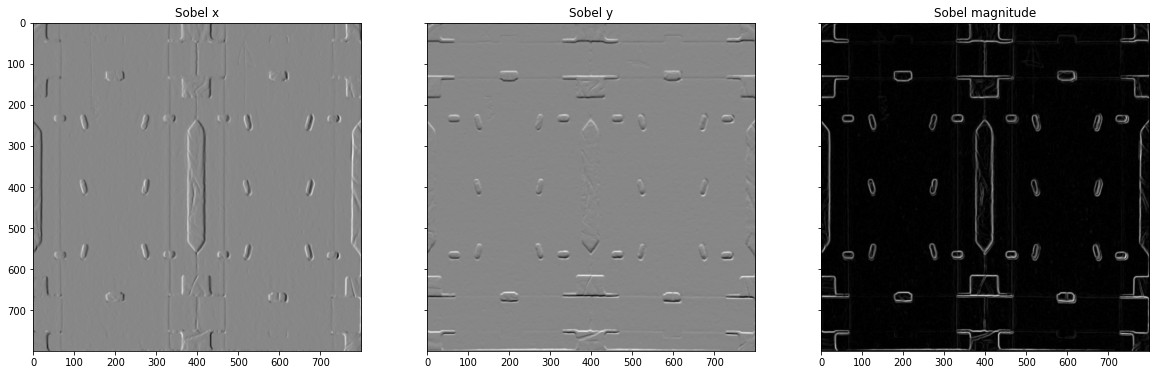

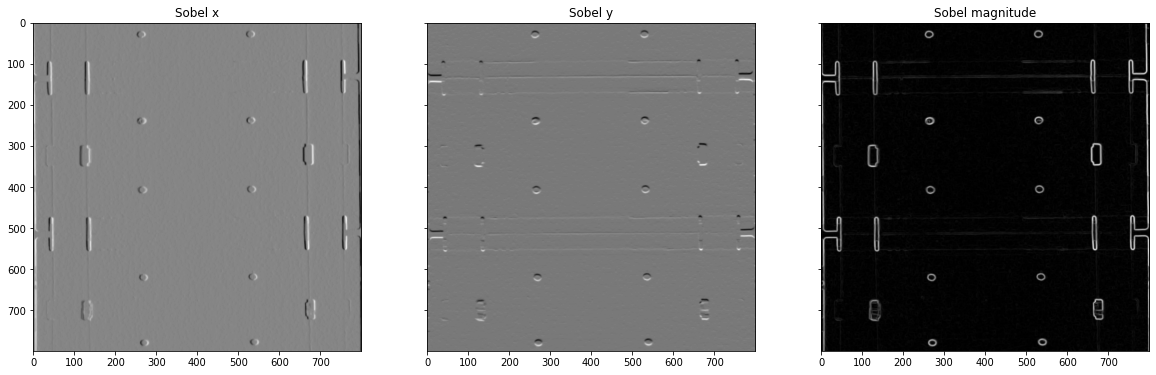

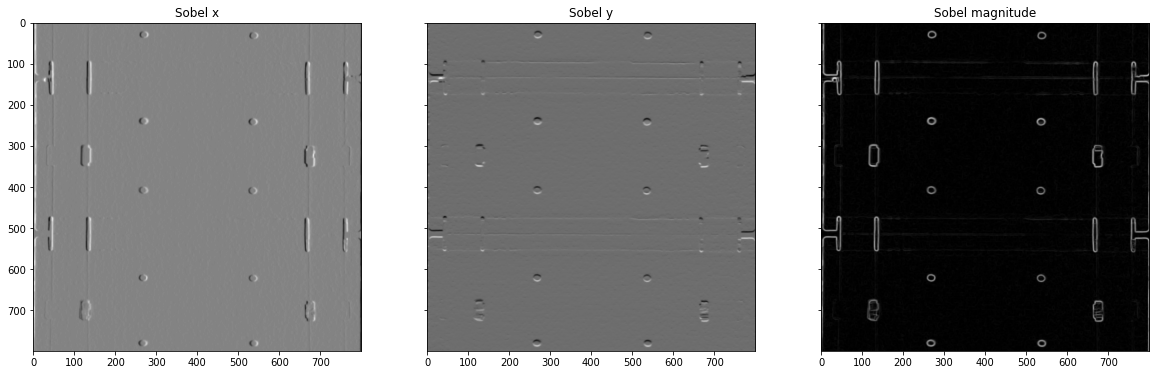

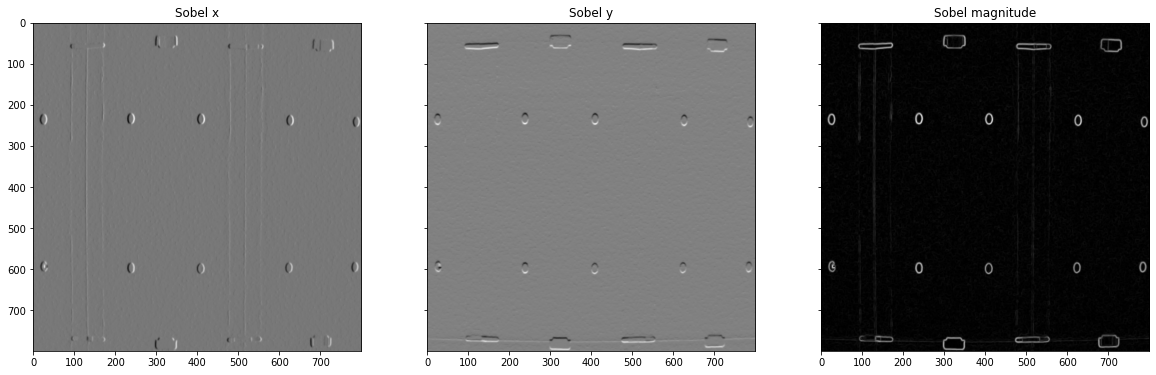

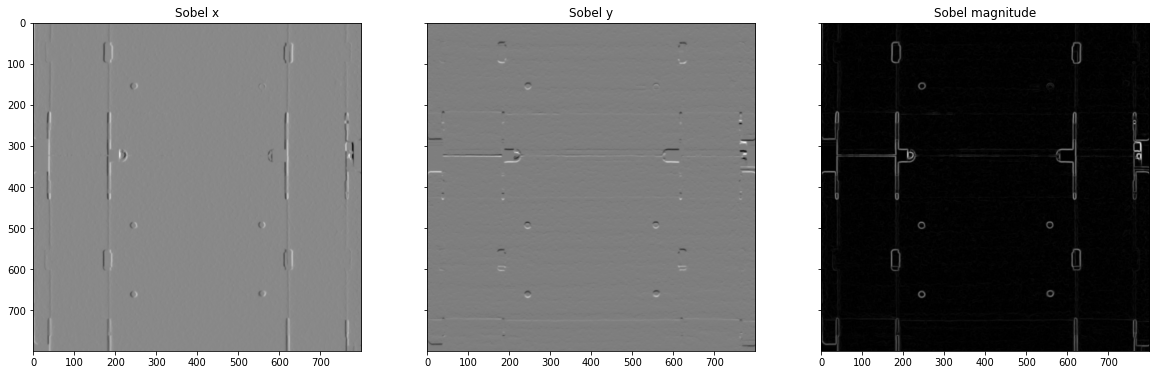

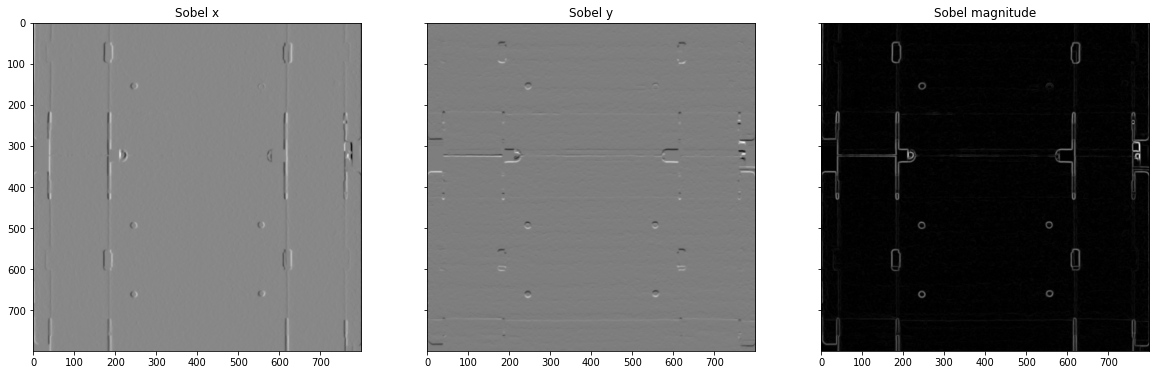

In [ ]:
# compute the derivatives with the horizontal and vertical sobel filters.
sobelx_images = [cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5, borderType=cv2.BORDER_DEFAULT) for img in mp_images]
sobely_images = [cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5, borderType=cv2.BORDER_DEFAULT) for img in mp_images]
sobelMagnitude_images = []

# compute the sobel magnitude 
for i in range(len(sobelx_images)):
  sobelMagnitude_images.append(np.sqrt( (np.power(sobelx_images[i],2) + np.power(sobely_images[i],2)) ))


# plot results
for i in range(len(sobelx_images)):
  fig, ax = plt.subplots(ncols=3, figsize=(20, 10), sharex=True, sharey=True)
  ax[0].imshow(sobelx_images[i], cmap=plt.cm.gray)
  ax[0].set_title('Sobel x')
  ax[1].imshow(sobely_images[i], cmap=plt.cm.gray)
  ax[1].set_title('Sobel y')
  ax[2].imshow(sobelMagnitude_images[i], cmap=plt.cm.gray)
  ax[2].set_title('Sobel magnitude')

In [ ]:
# normalize values betweeen 0 and 1
sobelMagNorm_images = []

for img in sobelMagnitude_images: 
  new_img = img = (img-np.min(img))/(np.max(img)-np.min(img))
  sobelMagNorm_images.append(new_img);

# 2) detection of the main lines: Canny edge detector + Hough line detection 

In [ ]:
# defintion of parameters for extracting main lines
 
parameters = [ {'sigma':0.01 , 'low_t': 0.75  , 'high_t':0.86  , 'hough_t':500, 'hough_angle':90  }  , 
               {'sigma':0.4  , 'low_t': 0.88 , 'high_t':0.925 , 'hough_t':380, 'hough_angle':10   }   , 
               {'sigma':0.8  , 'low_t': 0.89 , 'high_t':0.93  , 'hough_t':240, 'hough_angle':90 } , 
               {'sigma':0.4   , 'low_t':0.88  , 'high_t':0.962 , 'hough_t':450, 'hough_angle':90   } , 
               {'sigma':0.1  , 'low_t': 0.9  , 'high_t':0.955 , 'hough_t':450, 'hough_angle':90  } , 
               {'sigma':0.1  , 'low_t': 0.9  , 'high_t':0.94 , 'hough_t':470, 'hough_angle':90   } ]

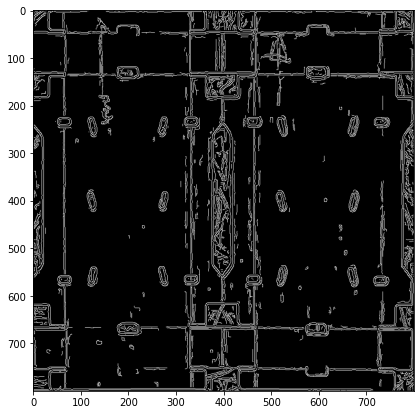

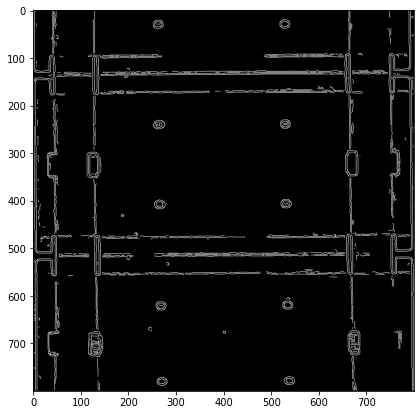

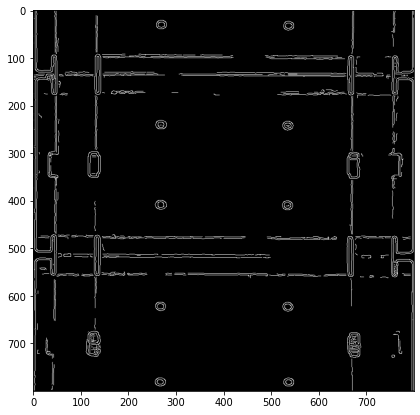

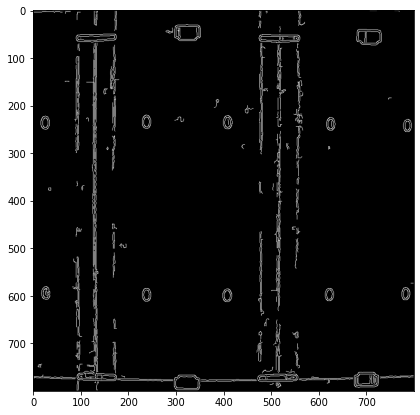

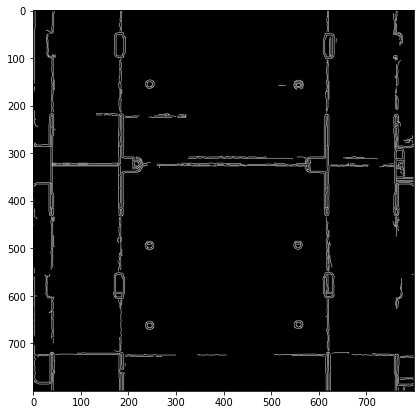

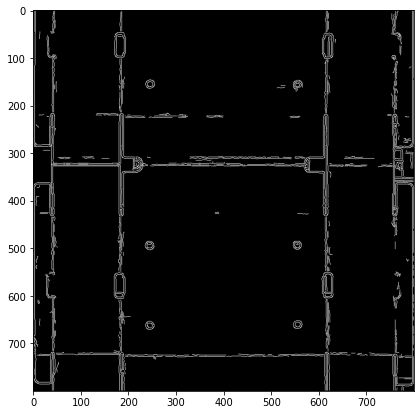

In [ ]:
# First part: use Canny edge extractor to detect the main lines.

canny_images = []

for i,img in enumerate(sobelMagNorm_images):
  # canny_edges = feature.canny(img, sigma =0.4)
  canny_edges = feature.canny(img, sigma = parameters[i]['sigma'], low_threshold = parameters[i]['low_t'],\
                              high_threshold= parameters[i]['high_t'], use_quantiles=True)

  fig,ax = plt.subplots(figsize=(10, 7))
  canny_images.append(canny_edges)
  ax.imshow(np.abs(canny_edges), "gray")

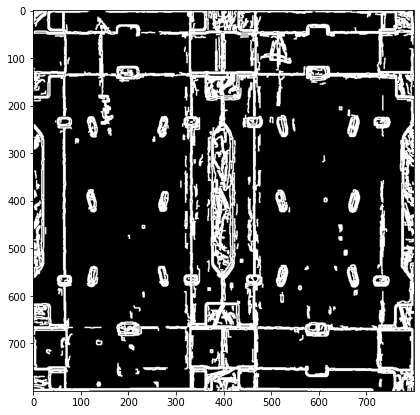

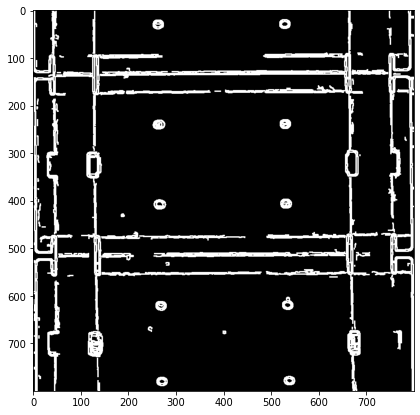

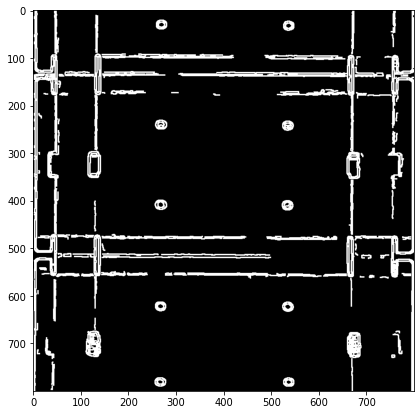

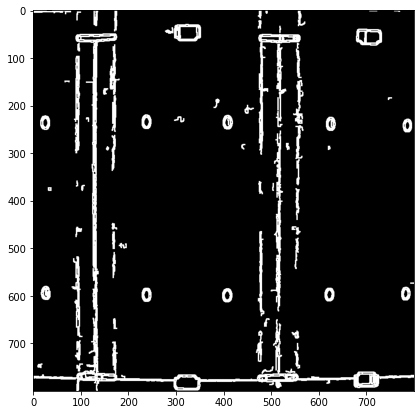

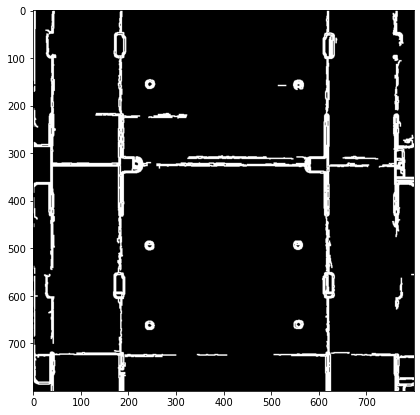

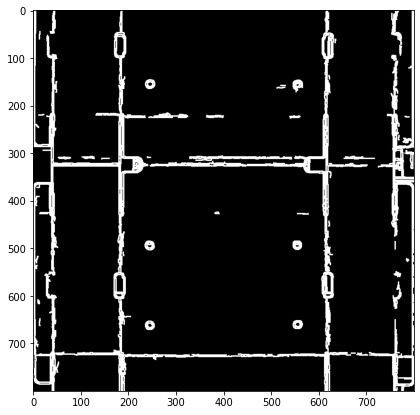

In [ ]:
# applicate dilation to highlight lines

canny_images_mp = []

dim = 3
for img in canny_images:

  dilation = scipy.ndimage.grey_dilation(img, footprint=np.ones((dim,dim)))
  
  canny_images_mp.append(dilation)
  fig,ax = plt.subplots(figsize=(10, 7))
  ax.imshow(dilation, cmap=plt.cm.gray)

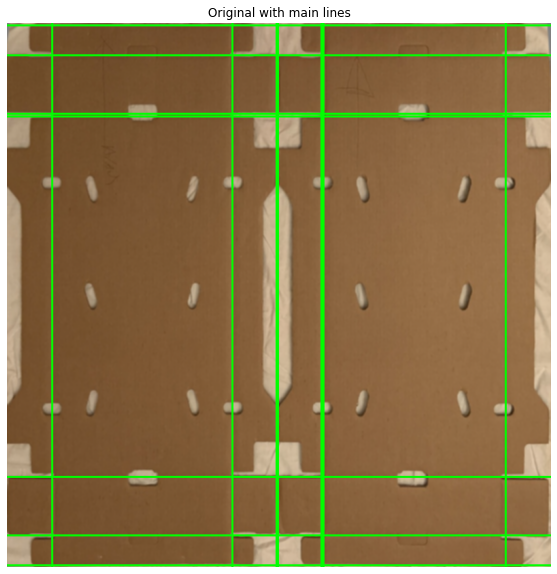

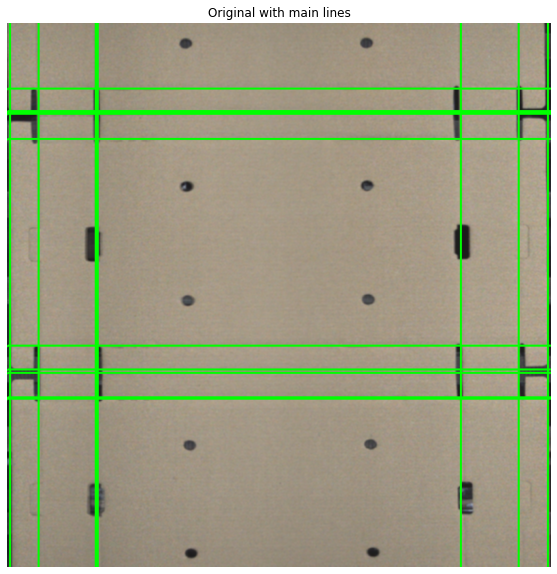

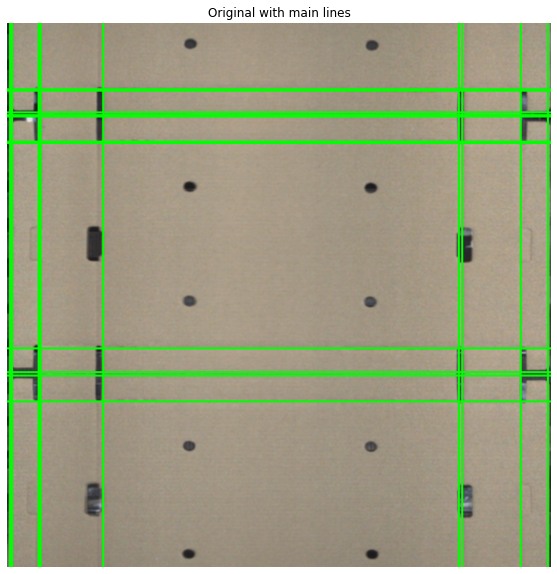

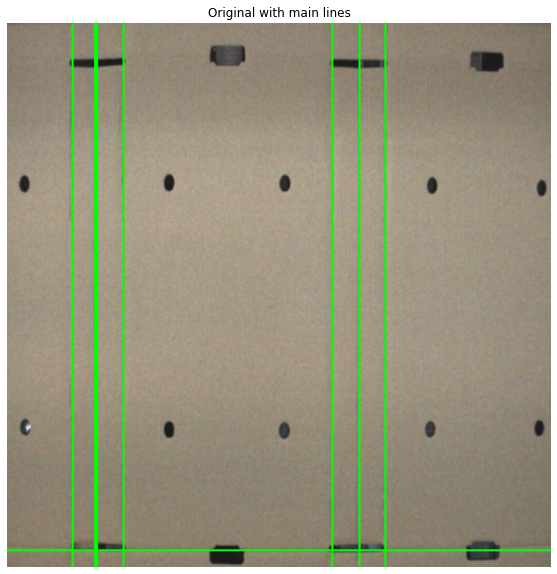

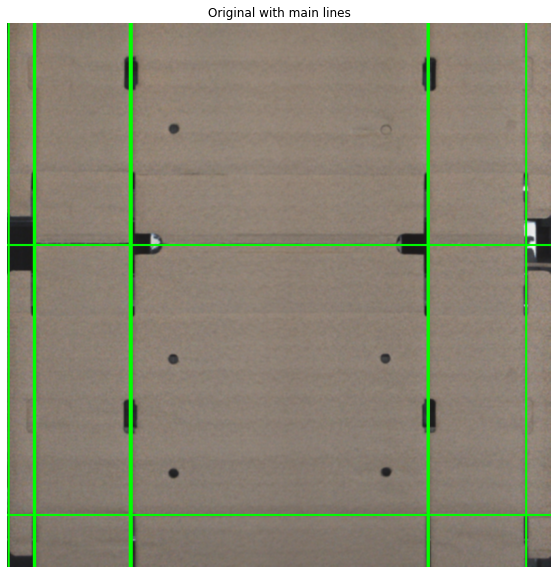

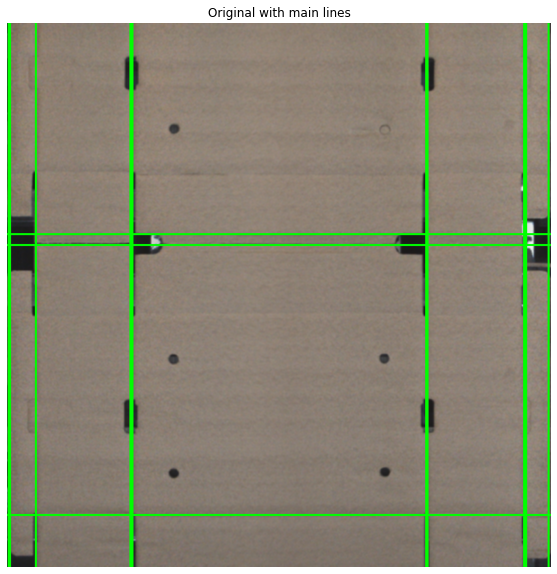

In [ ]:
for i,img in enumerate(canny_images_mp):

  # take the original image
  img_original = images_rgb[i].copy()

  # convert from boolean values to binary integer values
  img = skimage.img_as_int(img)
  img = img.astype(np.uint8)

  # extract the lines using Hough tranformation 
  # params: binary image, perpendicular distance, angle, threshold
  lines = cv2.HoughLines(img,1,parameters[i]['hough_angle']*np.pi/180,parameters[i]['hough_t'])


  # estimate the points to construct the lines and draw them
  if type(lines) != type(None):
    for item in lines:
      for rho,theta in item:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a)) 
        cv2.line(img_original,(x1,y1),(x2,y2),(0,255,0),2)
  # if i==num:
  fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
  ax1.imshow(img_original, cmap='gray')
  ax1.set_title("Original with main lines")
  ax1.axis('off')